# 作業 : (Kaggle)鐵達尼生存預測

# [教學目標]
- 以下用鐵達尼預測資料, 展示如何使用葉編碼, 並觀察預測效果
- 因為只有分類問題比較適合葉編碼, 因此範例與作業都使用鐵達尼的資料(二元分類問題)

# [教學目標]
- 了解葉編碼的寫作方式 : 使用梯度提升樹 (In[3]~In[5], Out[3]~Out[5])
- 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[6], Out[6], In[7], Out[7])

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))  # Series不是陣列，所以需要轉換
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
df = pd.DataFrame(MMEncoder.fit_transform(df))  # MMEncoder會得到一個ndarray
df.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [4]:
df.values

array([[1.        , 0.12134831, 1.        , ..., 0.01415106, 0.        ,
        1.        ],
       [0.        , 0.21348315, 0.        , ..., 0.13913574, 0.55782313,
        0.33333333],
       [1.        , 0.39662921, 0.        , ..., 0.01546857, 0.        ,
        1.        ],
       ...,
       [1.        , 0.46404494, 0.        , ..., 0.04577135, 0.        ,
        1.        ],
       [0.        , 0.09101124, 1.        , ..., 0.0585561 , 0.41496599,
        0.33333333],
       [1.        , 0.24719101, 1.        , ..., 0.01512699, 0.        ,
        0.66666667]])

In [5]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練集切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

In [15]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(222, 10)
(446, 10)
(222,)
(446,)


In [16]:
# 梯度提升樹調整參數並擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
# 調整參數的方式採用 RandomSearchCV 或 GridSearchCV, 以後的進度會再教給大家, 本次先直接使用調參結果
gdbt = GradientBoostingClassifier(subsample=0.93, n_estimators=320, min_samples_split=0.1, min_samples_leaf=0.3,
                                 max_features=4, max_depth=4, learning_rate=0.16)

onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

gdbt.fit(train_X, train_Y)
onehot.fit(gdbt.apply(train_X)[:, :, 0])  # gdbt.apply(train_X)本身會是一個3darray, 須經過[:, :, 0]的選擇才會成為2darray
lr.fit(onehot.transform(gdbt.apply(val_X)[:, :, 0]), val_Y)

/Users/paternhong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
print(gdbt.apply(train_X))

[[[2.]
  [2.]
  [3.]
  ...
  [1.]
  [1.]
  [1.]]

 [[2.]
  [2.]
  [4.]
  ...
  [1.]
  [1.]
  [2.]]

 [[2.]
  [2.]
  [3.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[2.]
  [2.]
  [3.]
  ...
  [2.]
  [1.]
  [1.]]

 [[2.]
  [2.]
  [3.]
  ...
  [2.]
  [1.]
  [2.]]

 [[1.]
  [1.]
  [1.]
  ...
  [2.]
  [2.]
  [1.]]]


In [8]:
gdbt.apply(train_X)[:, :, 0]

array([[2., 2., 3., ..., 1., 1., 1.],
       [2., 2., 4., ..., 1., 1., 2.],
       [2., 2., 3., ..., 1., 1., 1.],
       ...,
       [2., 2., 3., ..., 2., 1., 1.],
       [2., 2., 3., ..., 2., 1., 2.],
       [1., 1., 1., ..., 2., 2., 1.]])

In [22]:
# 將梯度提升樹+葉編碼+邏輯斯迴歸結果輸出
# http://sofasofa.io/forum_main_post.php?postid=1000600
pred_gdbt_lr = lr.predict_proba(onehot.transform(gdbt.apply(test_X)[:, :, 0]))[:, 1]  # [:, 1]代表為1的機率
# https://blog.csdn.net/u014264373/article/details/80487766
fpr_gdbt_lr, tpr_gdbt_lr, _ = roc_curve(test_Y, pred_gdbt_lr) # _為threshold，這邊用不到
# 將梯度提升樹結果輸出
pred_gdbt = gdbt.predict_proba(test_X)[:, 1]
fpr_gdbt, tpr_gdbt, _ = roc_curve(test_Y, pred_gdbt)

In [34]:
print(pred_gdbt_lr.shape)
print(fpr_gdbt_lr.shape)

(446,)
(179,)


In [41]:
print(pred_gdbt.max()) # 如果不指定pos_label，則thresholds會直接使用預測機率依照MAX > min來作為闕值
print(fpr_gdbt[1])
print(tpr_gdbt[1])
print(_[1])

0.8017106333782944
0.0
0.01639344262295082
0.8017106333782944


In [20]:
import matplotlib.pyplot as plt

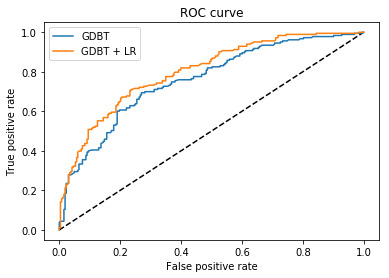

In [21]:
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gdbt, tpr_gdbt, label='GDBT')
plt.plot(fpr_gdbt_lr, tpr_gdbt_lr, label='GDBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?